#### The code and comments below have been adapted from Fast.ai deep learning course according to our specific needs.

In [1]:
from fastai.text import *
from fastai.plots import *
import html

ModuleNotFoundError: No module named 'bcolz'

In [6]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('../data/general/')

## Standardize format

In [7]:
CLAS_PATH=Path('../data/general_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('../data/general_lm/')
LM_PATH.mkdir(exist_ok=True)

In this section, we start cleaning up the messy text. There are 2 main activities we need to perform:

1. Clean up extra spaces, tab chars, new ln chars and other characters and replace them with standard ones
2. Use the awesome [spacy](http://spacy.io) library to tokenize the data. Since spacy does not provide a parallel/multicore version of the tokenizer, the fastai library adds this functionality. This parallel version uses all the cores of your CPUs and runs much faster than the serial version of the spacy tokenizer.

Tokenization is the process of splitting the text into separate tokens so that each token can be assigned a unique index. This means we can convert the text into integer indexes our models can use.

We use an appropriate chunksize as the tokenization process is memory intensive

In [4]:
chunksize=24000

In [5]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [6]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [7]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.

In [17]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'val.csv', header=None, chunksize=chunksize)
df_test = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [19]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLAS_PATH/'tmp'/'tok_test.npy', tok_test)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)
np.save(CLAS_PATH/'tmp'/'test_labels.npy', test_labels)


In [8]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_test = np.load(CLAS_PATH/'tmp'/'tok_test.npy')

In [8]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

27730

In [22]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
test_clas = np.array([[stoi[o] for o in p] for p in tok_test])

In [23]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)
np.save(CLAS_PATH/'tmp'/'test_ids.npy', test_clas)

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained IMDB backbone. The steps to create the classifier model are similar to the ones for the LM.

In [9]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')
test_clas = np.load(CLAS_PATH/'tmp'/'test_ids.npy')

In [10]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))
test_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'test_labels.npy'))

In [11]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [12]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
test_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a review at a time and learn to predict the it's sentiment as pos/neg. 

We have to pad the sequences to the same length in each batch. To create batches of similar sized reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [13]:
test_dl = None
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
test_ds = TextDataset(test_clas, test_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
# test_samp = SortSampler(test_clas, key=lambda x: len(test_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=0, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=0, pad_idx=1, sampler=val_samp)
test_dl = DataLoader(val_ds, batch_size=1, shuffle=False, transpose=True, num_workers=0, pad_idx=1, sampler=None)
md = ModelData(PATH, trn_dl, val_dl, test_dl=test_dl)
# md = ModelData(PATH, trn_dl, val_dl, test_dl=test_dl)

In [14]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.8

In [15]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [16]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [17]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [18]:
lr=3e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [19]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [20]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [26]:
learn.freeze_to(-1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|████████  | 2415/3000 [02:24<00:34, 16.73it/s, loss=1.19] 

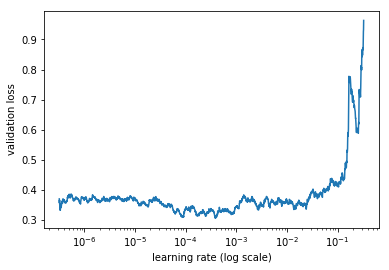

In [27]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [28]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  3%|▎         | 97/3000 [00:05<02:53, 16.74it/s, loss=0.346]

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.323505   0.213834   0.913333  



[array([ 0.21383]), 0.91333333444595333]

In [29]:
learn.save('clas_0')

In [30]:
learn.load('clas_0')

In [31]:
learn.freeze_to(-2)

In [32]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.29619    0.211335   0.913556  



[array([ 0.21134]), 0.91355555645624797]

In [33]:
learn.save('clas_1')

In [37]:
learn.load('clas_1')

In [38]:
learn.unfreeze()

In [39]:
learn.fit(lrs, 1, wds=wd, cycle_len=9, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=9), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.296921   0.19304    0.921111  
    1      0.229644   0.184868   0.927111                      
    2      0.254921   0.176965   0.930778                      
    3      0.258535   0.172831   0.930778                      
    4      0.230815   0.173452   0.931556                      
    5      0.223063   0.171706   0.932667                      
    6      0.207831   0.171242   0.932778                      
    7      0.234483   0.172179   0.932444                      
    8      0.212546   0.170062   0.933667                      



[array([ 0.17006]), 0.93366666555404665]

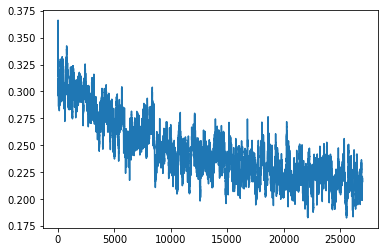

In [40]:
learn.sched.plot_loss()

In [41]:
learn.save('clas_2_general')

## Testing and confusion matrix

In [21]:
learn.load('clas_2_general')

In [22]:
log_preds, y = learn.predict_with_targs(is_test=True)

In [23]:
preds = np.exp(log_preds)
y_preds = np.argmax(preds, axis=1)
     

In [31]:
from sklearn.metrics import classification_report
print('Classification Report')
print('----------------------')
print(classification_report(y, y_preds, labels = [0, 1], target_names=['negative', 'positive']))
print('accuracy: {}'.format(round((y_preds==y).sum()/len(y), 2)))

Classification Report
----------------------
             precision    recall  f1-score   support

   negative       0.93      0.94      0.93      4430
   positive       0.94      0.93      0.93      4570

avg / total       0.93      0.93      0.93      9000

accuracy: 0.93


In [27]:
pd.crosstab(y, y_preds, rownames=['actual'], colnames=['predicted'], margins=True)

predicted,0,1,All
actual,,,
0,4169,261,4430
1,331,4239,4570
All,4500,4500,9000
